<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/detection_and_segmentation/Anomaly_Detection_with_Autoencoder_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anomaly Detection with Autoencoder**
Autoencoders are neural networks designed to learn a low dimensional representation given some input data. They consist of two components: an encoder (which learns to map input data to a low dimensional representation, termed the bottleneck), and a decoder (which learns to map this low dimensional representation back to the original input data). By structuring the learning problem in this manner, the encoder network learns an efficient “compression” function which maps input data to a salient lower dimension representation, such that the decoder network is able to successfully reconstruct the original input data. The model is trained by minimizing the reconstruction error: the difference (mean squared error) between the original input and the reconstructed output produced by the decoder.
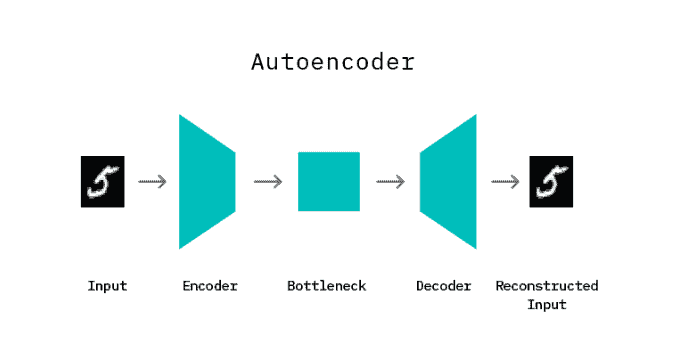 

# Use autoencoder to get the threshold for anomaly detection

It is important to note that the mapping function learned by an autoencoder is specific to the training data distribution, i.e., an autoencoder will typically not succeed at reconstructing data which is significantly different from data it has seen during training. This property of learning a distribution specific mapping (as opposed to a generic linear mapping) is particularly useful for the task of anomaly detection.

Applying an autoencoder for anomaly detection follows the general principle of first modeling normal behaviour and subsequently generating an anomaly score for a new data sample. To model normal behaviour we train the autoencoder on a normal data sample. This way, the model learns a mapping function that successfully reconstructs normal data samples with a very small reconstruction error (the difference between the actual sample and the version reconstructed by the model). This behavior is replicated at test time, where the reconstruction error is small for normal data samples, and large for abnormal data samples. To identify anomalies, we use the reconstruction error score as an anomaly score and flag samples with reconstruction errors above a given threshold.

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

load the data, here we used benchmark data in kaggle

In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [ ]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


Visualize the data: time series with anomalies and without anomalies

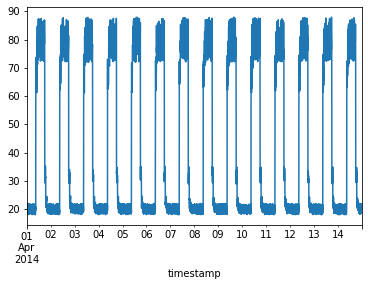

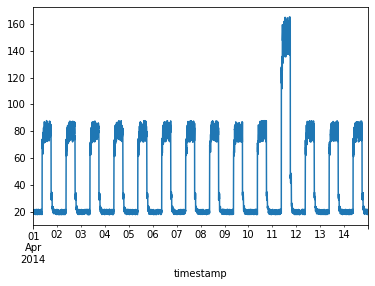

In [ ]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

Wrap up the function to preprocess the time series data, create sequences using raw data through time_steps set in advance.

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.

TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


def AE_anomaly_detection(x_train, x_test, time_steps=TIME_STEPS):
    training_mean = x_train.mean()
    training_std = x_train.std()
    df_training_value = (x_train - training_mean) / training_std
    print("Number of training samples:", len(df_training_value))

    x_train = create_sequences(df_training_value.values)
    print("Training input shape: ", x_train.shape)

    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
       ],
    )
    # Get train MAE loss.
    x_train_pred = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    print("Reconstruction error threshold: ", threshold)


##### test ...

    test_mean = x_test.mean()
    test_std = x_test.std()
    ####### prepare the test data
    df_test_value = (x_test - test_mean) / test_std
    #fig, ax = plt.subplots()
    #df_test_value.plot(legend=False, ax=ax)
    #plt.show()

    # Create sequences from test values.
    x_test = create_sequences(df_test_value.values)
    print("Test input shape: ", x_test.shape)

    # Get test MAE loss.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Detect all the samples which are anomalies.
    anomalies = test_mae_loss > threshold
    print("Number of anomaly samples: ", np.sum(anomalies))
    #print("Indices of anomaly samples: ", np.where(anomalies))
    return anomalies

Number of training samples: 4032
Training input shape:  (3745, 288, 1)
Epoch 1/50
27/27 [==============================] - 3s 99ms/step - loss: 0.5434 - val_loss: 0.1620
Epoch 2/50
27/27 [==============================] - 2s 90ms/step - loss: 0.0877 - val_loss: 0.0472
Epoch 3/50
27/27 [==============================] - 2s 89ms/step - loss: 0.0584 - val_loss: 0.0366
Epoch 4/50
27/27 [==============================] - 2s 89ms/step - loss: 0.0511 - val_loss: 0.0325
Epoch 5/50
27/27 [==============================] - 2s 89ms/step - loss: 0.0452 - val_loss: 0.0290
Epoch 6/50
27/27 [==============================] - 2s 89ms/step - loss: 0.0398 - val_loss: 0.0257
Epoch 7/50
27/27 [==============================] - 2s 88ms/step - loss: 0.0353 - val_loss: 0.0237
Epoch 8/50
27/27 [==============================] - 2s 88ms/step - loss: 0.0319 - val_loss: 0.0220
Epoch 9/50
27/27 [==============================] - 2s 89ms/step - loss: 0.0296 - val_loss: 0.0219
Epoch 10/50
27/27 [===================

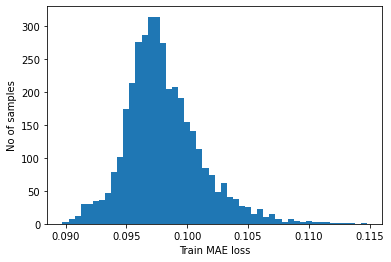

Reconstruction error threshold:  0.11477473792617432
Test input shape:  (3745, 288, 1)


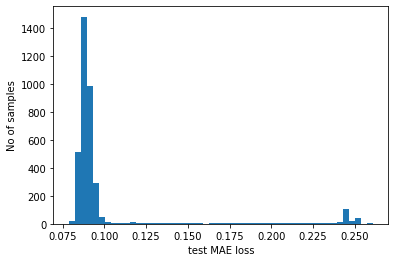

Number of anomaly samples:  369


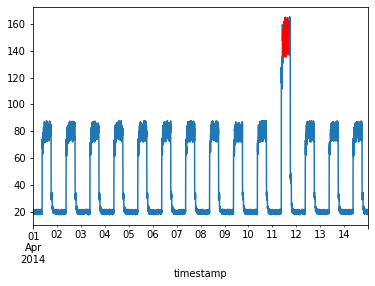

In [ ]:
##### plot anomalies
anomalies = AE_anomaly_detection(df_small_noise, df_daily_jumpsup, time_steps=TIME_STEPS)

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
test_mean = df_daily_jumpsup.mean()
test_std = df_daily_jumpsup.std()
df_test_value = (df_daily_jumpsup - test_mean) / test_std

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]

fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

## Pros and Cons of Autoencoder Algorithm for Anomaly Detection
**Pros**:
- An autoencoeder can perform tasks that a linear program cannot.
When an element of the neural network fails, it can continue without any problem with their parallel nature.
- An autoencoder constructed by neural network learns and does not need to be reprogrammed.
- It can be implemented in any application.

**Cons**: 
- The neural network needs training to operate.
- The architecture of a neural network is different from the architecture of microprocessors therefore needs to be emulated.
- Requires high processing time for large neural network